# AE4304P - Code - J.J. Knobbout, 4303385

This notebook is best viewed in full screen. Press the "Run" button to go through this notebook step by step. Click on "Kernel" and "Restart & Run All" to run the entire notebook.

#### Import standard required modules

In [1]:
import control.matlab as cont                    # To use control functions like bode, step, lsim, etc
import matplotlib.pyplot as plt                  # To plot graphs
import numpy as np                               # To work with arrays
import copy                                      # For creating a copy of the undamped state space system
from scipy.signal import welch, hanning          # For the Welch routine
from scipy.linalg import solve_lyapunov as lyap  # To use the lyapunov method to calculate variances.
from IPython.display import HTML, display, Math  # To display tables and state space systems in the notebook
import tabulate                                  # Idem
from decimal import Decimal                      # To format numbers with scientific notations
import warnings                                  # To clean up the notebook
warnings.filterwarnings('ignore')                # Hides warnings

#### Import module 'functions'.
This contains a function based on provided matlab code, in this case 'create_SS', which is based on cit2s.m and creates a state space system that includes gust effects. It has been converted to use with Python. This module can be found in the same folder this notebook is in.

In [2]:
import functions

### 1. Stability Analysis
#### 1.a Creating the state space systems
Creating the undamped state space system first, gust included:

In [3]:
undamped_sys = functions.create_SS()

This has created the following state-space system $\dot{x} = Ax + Bu$:

In [4]:
significant_digits = 2  # Set the number of significant digits for the state-space representation

# Import a function that neatly prints the state space system
from figures import neat_statespace

# Define the labels of all the variables
x_dot = np.transpose([[r"\dot{\hat{u}}", r"\dot{\alpha}", r"\dot{\theta}", r"\frac{\dot{q}\bar{c}}{V}", r"\dot{\hat{u}}_g", \
                       r"\dot{\alpha}_g", r"\dot{\alpha}^{*}_g"]])
x = np.transpose([[r"\hat{u}", r"\alpha", r"\theta", r"\frac{q\bar{c}}{V}", r"\hat{u}_g", r"\alpha_g", r"\alpha^{*}_g"]])
u = np.transpose([[r"\delta_e", r"w_1", r"w_3"]])

# Print to 2 significant digits (last variable of this function)
display(Math(neat_statespace(undamped_sys.A, undamped_sys.B, u, x, x_dot, significant_digits)))

<IPython.core.display.Math object>

with $y = Cx + Du$, where C is an identity matrix of size 7 and D a zero matrix with the same shape as matrix B.

The damped system is a copy of the undamped system that includes an active feedback loop with the control law $\delta_e = K_{\theta}$. The value of $K_\theta$ should be chosen such that the damping ratio of the phugoid is equal to $0.5$, which can be determined with the root locus plot of the undamped system.

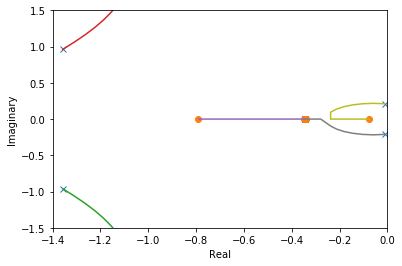

In [5]:
#Taking a large enough range for the gain and adjusting the window size to fit every section.
rlist, klist = cont.rlocus(undamped_sys[2,0], \
                           kvect=np.linspace(0, -50.0, num=1000), \
                           xlim=[-1.4,0], \
                           ylim=[-1.5,1.5])

A downside of this web-based notebook is that this root locus plot is not interactive. An offline (interactive and clickable) version shows that the required gain lies around -0.11. This can be shown here as well by comparing the damping ratios obtained by using the 2 gain values closest to -0.11:

In [6]:
# Gain values before and after -0.11:
gain1 = klist[2]
gain2 = klist[3]

# Define s variable
s = cont.tf([1, 1],[1])-1

# Every gain value has a number of root locations plotted 
# (1 for every root locus section). 
# Get the two roots from the phugoid sections and multiply them together
# to find the characteristic equations:
char_equation1 = (s - rlist[2][5])*(s - rlist[2][6])
char_equation2 = (s - rlist[3][5])*(s - rlist[3][6])

# Characteristic equations are now in transfer function form, retrieve 
# the equations from the numerators:
num1, dummy1 = cont.tfdata(char_equation1)
num2, dummy2 = cont.tfdata(char_equation2)

# Recall that the characteristic equation has standard form 
# s^2 + 2*zeta*wn + wn^2 and determine zetas:
zeta1 = num1[0][0][1]/(2*(num1[0][0][2]**0.5))
zeta2 = num2[0][0][1]/(2*(num2[0][0][2]**0.5))

print "For a gain value of "+str(round(gain1,5))+ \
      ", the damping ratio becomes "+str(round(zeta1.real,5))+"."
print "For a gain value of "+str(round(gain2,5))+ \
      ", the damping ratio becomes "+str(round(zeta2.real,5))+"."

For a gain value of -0.1001, the damping ratio becomes 0.44517.
For a gain value of -0.15015, the damping ratio becomes 0.59875.


The proper gain value is therefore somewhere in between.

Finetuning this value with trial and error in Python eventually results in a more exact gain value of -0.117017. The damped system can now be found:

In [7]:
from figures import neat_statespace_compare

# First create a copy of the undamped system:
damped_sys = copy.deepcopy(undamped_sys)

# Create a feedback vector with K_theta at the theta position.
K_theta = -0.117017
K = [0, 0, K_theta, 0, 0, 0, 0]

# Add the feedback loop:
damped_sys.A = undamped_sys.A - undamped_sys.B[:,0]*K

This damped system looks as follows, with changes compared to the undamped system printed in bold:

In [8]:
significant_digits = 2

display(Math(neat_statespace_compare(damped_sys.A, damped_sys.B, undamped_sys.A, undamped_sys.B, u, x, x_dot, 
                                     significant_digits)))

<IPython.core.display.Math object>

The code for these state space representations can be found in the 'figures' module.

Now there are state space systems for the damped and undamped case. Comparing the damping ratios of the phugoid eigenmotions shows that the damped system is properly damped:

In [9]:
# Round damping ratio to 5 nearest digits and select the damping ratios
# that belong to the phugoid eigenmotions.
zeta_undamped = round(cont.damp(undamped_sys,doprint=False)[1][2],5)
zeta_damped = round(cont.damp(damped_sys,doprint=False)[1][2],5)

print "Undamped damping ratio: "+str(zeta_undamped)
print "Damped damping ratio: "+str(zeta_damped)

Undamped damping ratio: 0.05038
Damped damping ratio: 0.5


The new damping ratio is 0.50000, rounded to the nearest 5 digits.

#### 1.b) Analysis of results
A quick comparison of the step responses of both systems can give an indication of the stability of the systems.

In [ ]:
# Create a large enough time scale
t = np.arange(0,100,0.01)

# Retrieve theta step response to default inputs
[y1, t] = cont.step(undamped_sys[2,0], t)
[y2, t] = cont.step(damped_sys[2,0], t)
                 
# Plot the figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t, -y1, label="Undamped")
ax.plot(t, -y2, label="Damped")
ax.set_xlim([0,100])
plt.xlabel('Time [s]')
plt.ylabel(r"$\theta$ [$\degree$]")
plt.legend(loc='upper right')
plt.title("Step response comparison")
plt.grid()
plt.show()

Both systems appear stable and the system with the feedback loop is much better damped. The pole map below confirms that both systems are stable:

In [ ]:
# Create function to make complex numbers prettier:
def formatComplexEV(ev, decimals):
    return str(round(np.real(ev), decimals))+r' $\pm$ '+str(round(np.imag(ev), decimals))+'j'

# Retrieves poles and manually plot them to allow for more formatting options
p_u, z_u = cont.pzmap(undamped_sys[2,0], Plot=False);
p_d, z_d = cont.pzmap(damped_sys[2,0], Plot=False);

plt.title("Pole map")
plt.scatter(np.real(p_u), np.imag(p_u), 80, marker='x', label='Undamped');
plt.scatter(np.real(p_d), np.imag(p_d), 80, marker='x', label='Damped');
plt.xlabel('Re [-]');
plt.ylabel('Im [-]')
plt.axhline(y=0, color='black', linestyle='-');
plt.axvline(x=0, color='black', linestyle='-');

plt.text(1.1, 0.8, "Undamped eigenvalues:", fontsize=14, transform=plt.gcf().transFigure);
plt.text(1.1, 0.7, "Short period: "+formatComplexEV(cont.damp(undamped_sys,doprint=False)[2][0],4), 
         fontsize=12, transform=plt.gcf().transFigure);
plt.text(1.1, 0.6, "Phugoid: "+formatComplexEV(cont.damp(undamped_sys,doprint=False)[2][2],4), 
         fontsize=12, transform=plt.gcf().transFigure);

plt.text(1.1, 0.4, "Damped eigenvalues:", fontsize=14, transform=plt.gcf().transFigure);
plt.text(1.1, 0.3, "Short period: "+formatComplexEV(cont.damp(damped_sys,doprint=False)[2][0],4), 
         fontsize=12, transform=plt.gcf().transFigure);
plt.text(1.1, 0.2, "Phugoid: "+formatComplexEV(cont.damp(damped_sys,doprint=False)[2][2],4), 
         fontsize=12, transform=plt.gcf().transFigure);

plt.legend();

All poles are located in the left-hand pane, so all the eigenvalues of both the damped and undamped short periods and phugoids have negative real parts, which means that both systems are longitudinally stable.

### 2. Time-Domain Analysis
Both the damped and undamped state-space systems created in the previous section will be extended to include the load factor $n_z = \frac{a_z}{g}$. The acceleration $a_z$ can be estimated with $V\dot{\gamma}$. Knowing that $\gamma = \theta - \alpha$, the time derivative is $\dot{\gamma} = q - \dot{\alpha}$. The load factor $n_z$ can therefore be included using: $\frac{V}{g}(q - \dot{\alpha})$.

In [ ]:
# Values provided by the assignment:
V_trim = 51.4
c = 2.022
g = 9.80655

# Two systems have to be extended, so it's easier to create a function for 
# it and use it twice:
def extend_ss(ss):
    
    # Only the output is extended, so only the C and D matrices. 
    # The fourth output variable is qc/V,
    # so V/c is multiplied by that variable to retrieve q:
    C_extension = V_trim/g * ((V_trim/c)*np.array([0, 0, 0, 1, 0, 0, 0]) - ss.A[1,:])
    
    D_extension = V_trim/g * (-ss.B[1,:]) 
    
    # The new state-space matrices are:
    A = ss.A
    B = ss.B
    C = np.vstack((ss.C, C_extension))
    D = np.vstack((ss.D, D_extension))
    
    # Return a new state-space system with these arrays:
    return cont.ss(A, B, C, D)

# Update the state-space systems:
undamped_sys = extend_ss(undamped_sys)
damped_sys = extend_ss(damped_sys)

### NOTE!!, re-running this cell will keep extending the state space systems!

This causes the undamped and damped system's $y = Cx + Du$ equation to look as follows, with the changes in the damped system compared to the undamped system again printed in bold:

In [ ]:
x_dot = "y" #Defining x_dot as a single string will prevent neat_statespace() from attempting to iterate over it
x = np.transpose([[r"\hat{u}", r"\alpha", r"\theta", r"\frac{q\bar{c}}{V}", r"\hat{u}_g", r"\alpha_g", r"\alpha^{*}_g", \
                   "n_z"]])

display(Math(r"Undamped:"))
display(Math(neat_statespace(undamped_sys.C, undamped_sys.D, u, x, x_dot, 2)))

display(Math(r"Damped:"))
display(Math(neat_statespace_compare(damped_sys.C, damped_sys.D, undamped_sys.C, undamped_sys.D, u, x, x_dot, 2)))


The $\dot{x} = Ax + Bu$ equation of the state space systems remains the same.

A time-domain analysis will be performed on all aircraft states for both systems: $V$, $\alpha$, $\theta$, $\frac{qc}{V}$, and the added state $n_z$. The only input for these analyses will be vertical turbulence. The provided matlab file exampl74b.m shows how to plot the time responses of such systems:

In [ ]:
# Set time settings, these will also be used for the experimental routines
T = 1000
dt = 0.1

t = np.arange(0,T,dt)
N = len(t)

# A seed is initialised to ensure the reproducibility of the results:
np.random.seed(20)

# Create an input array:
input_delta_e = np.zeros((1,N))
input_w1 = np.zeros((1,N))
input_w3 = np.random.randn(1,N)/np.sqrt(dt)

input_array = np.transpose(np.vstack((input_delta_e, input_w1, input_w3)))

# Time analysis will be done for both systems, so again a function is useful:
def time_analysis(ss):
    
    # Create an output
    y, dummy1, dummy2 = cont.lsim(ss, U=input_array, T=t)
    
    # Extract aircraft states from output:
    V = y[:,0]
    alpha = y[:,1]
    theta = y[:,2]
    qc_V = y[:,3]
    n_z = y[:,7]
    
    # Convert states to SI units and absolute values:
    V = V*V_trim + V_trim
    alpha = alpha*180./np.pi
    theta = theta*180./np.pi
    q = qc_V*V_trim*(180./np.pi)/c
    
    # Return the states
    return V, alpha, theta, q, n_z, [V, alpha, theta, q, n_z]

V_undamped, alpha_undamped, theta_undamped, q_undamped, n_z_undamped, undamped_time_data = time_analysis(undamped_sys)
V_damped, alpha_damped, theta_damped, q_damped, n_z_damped, damped_time_data = time_analysis(damped_sys)

The damped and undamped responses will be plotted against each other to immediately tell the difference. The code for plotting these figures can be found in the 'figures' module.

In [ ]:
from figures import create_time_domain_figures

# General graph settings
fig_width = 15
fig_height = 20
line_width = 1
label_fontsize = 12
subplot_vspace = 0.05

create_time_domain_figures(T, t, damped_time_data, undamped_time_data, 
                           fig_width, fig_height, line_width, label_fontsize, 
                           subplot_vspace)

### 3. Spectral analysis

For the previously analysed aircraft states, calculate:

#### 3.a Analytical Power Spectral Density functions using the state-space representation
An analytical PSD has to be found for all five variables. The provided matlab file exampl83.m shows how to compute analytical PSDs to horizontal lateral turbulence. This method will be used for the case of vertical turbulence. It is based on the formula $S_{\bar{y}\bar{y}}(\omega) = |H(\omega)|^2 \cdot W$, where $W$ is the power spectral density of the input $\bar{u}(t)$, which is set at 1.

In [ ]:
# Again a function is useful to compute the PSD for 5 different variables:

# For a given state-space system, create an analytical PSD (aPSD) for a certain
# input/output combination.
def create_aPSD(ss, input_index, output_index, w):
    mag, dummy1, dummy2 = cont.bode(ss[output_index,input_index], w, Plot=False)
    return mag*mag

# Create logarithmic frequency scale
w_aPSD = np.logspace(-2,2,500)

# Input is vertical gust, third input (index = 2)
aPSD_V_undamped = create_aPSD(undamped_sys, 2, 0, w_aPSD)
aPSD_alpha_undamped = create_aPSD(undamped_sys, 2, 1, w_aPSD)
aPSD_theta_undamped = create_aPSD(undamped_sys, 2, 2, w_aPSD)
aPSD_q_undamped = create_aPSD(undamped_sys, 2, 3, w_aPSD)
aPSD_n_z_undamped = create_aPSD(undamped_sys, 2, 7, w_aPSD)

undamped_aPSD_data = [aPSD_V_undamped, aPSD_alpha_undamped, aPSD_theta_undamped, 
                      aPSD_q_undamped, aPSD_n_z_undamped]

aPSD_V_damped = create_aPSD(damped_sys, 2, 0, w_aPSD)
aPSD_alpha_damped = create_aPSD(damped_sys, 2, 1, w_aPSD)
aPSD_theta_damped = create_aPSD(damped_sys, 2, 2, w_aPSD)
aPSD_q_damped = create_aPSD(damped_sys, 2, 3, w_aPSD)
aPSD_n_z_damped = create_aPSD(damped_sys, 2, 7, w_aPSD)

damped_aPSD_data = [aPSD_V_damped, aPSD_alpha_damped, aPSD_theta_damped, 
                    aPSD_q_damped, aPSD_n_z_damped]

Before plotting these figures, the experimental analyses will be performed. This way, all the PSDs can be plotted together to really get an impression of the differences between these methods.

#### 3.b Experimental PSD
This method is based on the equation:


$S_{\bar{y}\bar{y}}(\omega) = dt \cdot \lim_{N \to \infty}E\{\frac{1}{N}\bar{Y}^*[k]\bar{Y}[k]\}$

An example of how to code this is shown in Matlab file exampl44.m.


In [ ]:
# Set sampling settings, these will also be used for the pwelch routine later on

fs = 1./dt
w_ePSD = 2*np.pi*fs*np.arange(0,(float(N)/2.))/float(N)

# Recreate the time series, but this time skip the conversion to SI units
# The same seed is initialised to ensure that the input array stays the same as before
np.random.seed(20)

# Create an input array:
input_delta_e = np.zeros((1,N))
input_w1 = np.zeros((1,N))
input_w3 = np.random.randn(1,N)/np.sqrt(dt)

input_array = np.transpose(np.vstack((input_delta_e, input_w1, input_w3)))

y_undamped, dummy1, dummy2 = cont.lsim(undamped_sys, input_array, t)
y_damped, dummy1, dummy2 = cont.lsim(damped_sys, input_array, t)

### These collections are for later when calculating variances with np.var()
time_data_undamped = [y_undamped[:,0],y_undamped[:,1],y_undamped[:,2],y_undamped[:,3],y_undamped[:,7]]
time_data_damped = [y_damped[:,0],y_damped[:,1],y_damped[:,2],y_damped[:,3],y_damped[:,7]]
###

# Now create the experimental PSDs using the fft routine from numpy.fft
def create_ePSD(var):
    var_f = dt*np.fft.fft(var)
    S_var = (1./T)*(var_f*np.conj(var_f))
    return S_var[0:N/2]

ePSD_V_undamped = create_ePSD(y_undamped[:,0])
ePSD_alpha_undamped = create_ePSD(y_undamped[:,1])
ePSD_theta_undamped = create_ePSD(y_undamped[:,2])
ePSD_q_undamped = create_ePSD(y_undamped[:,3])
ePSD_n_z_undamped = create_ePSD(y_undamped[:,7])

undamped_ePSD_data = [ePSD_V_undamped, ePSD_alpha_undamped, 
                      ePSD_theta_undamped, ePSD_q_undamped, ePSD_n_z_undamped]

ePSD_V_damped = create_ePSD(y_damped[:,0])
ePSD_alpha_damped = create_ePSD(y_damped[:,1])
ePSD_theta_damped = create_ePSD(y_damped[:,2])
ePSD_q_damped = create_ePSD(y_damped[:,3])
ePSD_n_z_damped = create_ePSD(y_damped[:,7])

damped_ePSD_data = [ePSD_V_damped, ePSD_alpha_damped, ePSD_theta_damped, 
                    ePSD_q_damped, ePSD_n_z_damped]

Now that the FFT analyses are done and stored, the Welch routine is up next, which is performed below by simply using scipy's welch function.

In [ ]:
# Set window size not too large, or noise will remain, but not too small, or lower frequencies and resonance peaks are not
# accurately presented
win = hanning(500, True)

# Set overlap at 50% (too high and the noise again remains)
noverlap = 250

# Code here is based on provided Matlab file exampl45.m
def pwelch(data):
    f, pPSD = welch(data, fs=fs,nfft=int(N),noverlap=noverlap, return_onesided=True, detrend=False, window=win)
    f = f[0:(int(N)/2)+1]
    pPSD = pPSD/2.
    pPSD = pPSD[0:(int(N)/2)+1]
    
    return f, pPSD

f, pPSD_V_undamped = pwelch(y_undamped[:,0])
dummy, pPSD_alpha_undamped = pwelch(y_undamped[:,1])
dummy, pPSD_theta_undamped = pwelch(y_undamped[:,2])
dummy, pPSD_q_undamped = pwelch(y_undamped[:,3])
dummy, pPSD_n_z_undamped = pwelch(y_undamped[:,7])

undamped_pPSD_data = [pPSD_V_undamped, pPSD_alpha_undamped, pPSD_theta_undamped, pPSD_q_undamped, pPSD_n_z_undamped]

dummy, pPSD_V_damped = pwelch(y_damped[:,0])
dummy, pPSD_alpha_damped = pwelch(y_damped[:,1])
dummy, pPSD_theta_damped = pwelch(y_damped[:,2])
dummy, pPSD_q_damped = pwelch(y_damped[:,3])
dummy, pPSD_n_z_damped = pwelch(y_damped[:,7])

damped_pPSD_data = [pPSD_V_damped, pPSD_alpha_damped, pPSD_theta_damped, pPSD_q_damped, pPSD_n_z_damped]

Now plot the analytical PSD together with both experimental routines (FFT and PWELCH) to compare them all:

In [ ]:
from figures import create_PSD_figures

# General graph settings
fig_width = 13
fig_height = 40
line_width = 1
label_fontsize = 12
subplot_vspace = 0.15
titles = [r"$\hat{u}$",r"$\alpha$",r"$\theta$",r"$\frac{qc}{V}$",r"$n_z$"]
ylabels = [r"$S_{\hat{u}\hat{u}}$  $\left[\frac{rad^2}{rad/s}\right]$", 
           r"$S_{\alpha\alpha}$  $\left[\frac{rad^2}{rad/s}\right]$",
           r"$S_{\theta\theta}$  $\left[\frac{rad^2}{rad/s}\right]$",
           r"$S_{qq}$  $\left[\frac{rad^2}{rad/s}\right]$",
           r"$S_{nn}$  $\left[\frac{rad^2}{rad/s}\right]$"]

w_pPSD = 2*np.pi*f

for i in [0,1,2,3,4]:
    
    create_PSD_figures(w_aPSD, w_ePSD, w_pPSD, damped_aPSD_data[i],
                        undamped_aPSD_data[i], damped_ePSD_data[i], undamped_ePSD_data[i], 
                        damped_pPSD_data[i], undamped_pPSD_data[i], fig_width, 
                        fig_height, line_width, label_fontsize, subplot_vspace, ylabels[i])
    plt.suptitle("Analytical and Experimental PSDs for state variable "+titles[i], x=0.5, y=0.91, fontsize=14, weight='bold')
    


### 4. Variances
#### 4.a. FIrst the variances are calculated by crude integrating the analytical power spectra for all 5 states (n = 5).

In [ ]:
# This code is based on the Matlab exampl74a.m file, which also
# uses this crude integration method.
n = 5
aVar_undamped = np.zeros((1,n))
aVar_damped = np.zeros((1,n))

for i in range(0,len(w_aPSD)-1):
    for j in range(0, n):
        aVar_undamped[0][j] = aVar_undamped[0][j] + (w_aPSD[i+1] - w_aPSD[i])*undamped_aPSD_data[j][i]
        aVar_damped[0][j] = aVar_damped[0][j] + (w_aPSD[i+1] - w_aPSD[i])*damped_aPSD_data[j][i]

aVar_undamped = aVar_undamped[0]/np.pi
aVar_damped = aVar_damped[0]/np.pi

#### 4.b Then the variances are calculated by solving the Lyapunov equation

In [ ]:
# This code is based on the Matlab exampl72.m file, which also
# uses this method to solve the lyapunov equation.
# Ran into some problems using control.lyap, so scipy's version is
# used instead

W = 1.0 # Set intensity at 1

def var_lyap(ss):
    A = ss.A
    B = ss.B[:,2] # Only the third input
    C = ss.C
    D = ss.D
    
    # Solve lyapunov equation:
    
    L = lyap(A, B*W*np.transpose(B))

    # Manually retrieve the load factor variance as this is not included
    # in matrix A
    
    C_n_z = C[7,:]
    D_n_z = D[7,:]

    var_n_z = C_n_z*L*np.transpose(C_n_z) + D_n_z*W*np.transpose(D_n_z)

    # Return the first 4 state variances and the load factor variance

    return abs(np.hstack((np.diag(L[0:4, 0:4]), float(var_n_z))))

lVar_undamped = var_lyap(undamped_sys)
lVar_damped = var_lyap(damped_sys)

#### 4.c Finally, the variances are determined with np.var() (equivalent to Matlab's var.m)

In [ ]:
vVar_undamped = np.var(time_data_undamped, 1)
vVar_damped = np.var(time_data_damped, 1)

Plotting the tables of variances:

In [ ]:
# First create an empty table format with labels:
table_format = [["","$\sigma^2_\hat{u}$",r"$\sigma^2_\alpha$",r"$\sigma^2_\theta$",r"$\sigma^2_\frac{qc}{V}$",
                 r"$\sigma^2_{n_z}$"],
                [r"$\textbf{Analytical}$", 0, 0, 0, 0, 0],
                [r"$\textbf{Lyapunov}$", 0, 0, 0, 0, 0],
                [r"$\textbf{Var}$", 0, 0, 0, 0, 0]]

# Collect all calculated variances in an array:
vars_undamped = np.vstack((aVar_undamped, np.vstack((lVar_undamped, vVar_undamped))))
vars_damped = np.vstack((aVar_damped, np.vstack((lVar_damped, vVar_damped))))

# Iterate over the array and position variances in correct table locations
for i in range(1,4):
    for j in range(1,6):
        table_format[i][j] = "{:.4e}".format(Decimal(vars_undamped[i-1][j-1]))

# Display the table
display(Math("\\text{Undamped variances:}"))
display(HTML(tabulate.tabulate(table_format, tablefmt='html')))

# Idem, but for damped variances
for i in range(1,4):
    for j in range(1,6):
        table_format[i][j] = "{:.4e}".format(Decimal(vars_damped[i-1][j-1]))
        
display(Math("\\text{Damped variances:}"))
display(HTML(tabulate.tabulate(table_format, tablefmt='html')))

Determine how much smaller the damped variances are compared to the undamped variances:

In [ ]:
for i in range(1,6):
    for j in range(1,4):
        table_format[j][i] = "{:.4}".format(Decimal(vars_undamped[j-1][i-1]/vars_damped[j-1][i-1]))

display(Math("\\text{Damped variances are smaller than undamped variances by these factors:}"))
display(HTML(tabulate.tabulate(table_format, tablefmt='html')))

That concludes this notebook